총 785행, 파일 5개 로드
methods: ['dr', 'gerryfair', 'multicalib', 'reduction', 'sequential']
{'dr': 'lambda_fair', 'gerryfair': 'gamma', 'multicalib': 'mc_alpha', 'reduction': None, 'sequential': 'seq_alpha'}


/tmp/ipykernel_3319829/1783383673.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


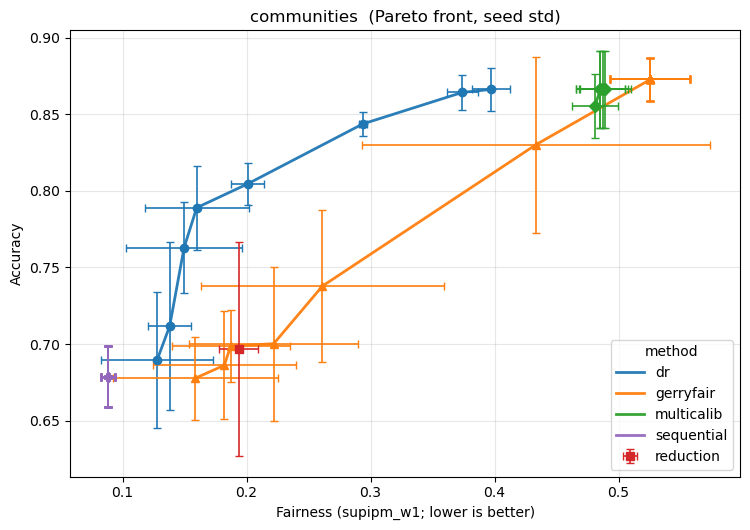

In [33]:
import os, math, warnings
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

# ===== 설정 =====
DATASET = "communities"  # "communities", "dutch" 등
CSV_SOURCES = [
    f"results_old/dr_{DATASET}/all_results.csv",
    f"results_old/reduction_{DATASET}/all_results.csv",
    f"results_old/gerryfair_{DATASET}/all_results.csv",
    f"results_old/mc_{DATASET}/all_results.csv",
    f"results_old/seq_{DATASET}/all_results.csv",
]
SEED_AGG = "mean"             # "mean" or "median"
SAVE_FIG = None               # ex) f"tradeoff_{DATASET}.png"
TITLE = f"{DATASET}"

# x축에 쓸 단일 공정성 지표 지정
FAIRNESS_KEY = "supipm_w1"    # 예: "supipm_w1", "supipm_rbf", "spd_worst", "spd_mean"

# 컨트롤 파라미터 후보
CONTROL_COLS = {
    "dr":          ["lambda_fair"],
    "reduction":   ["red_eps", "eps", "red_lambda"],
    "gerryfair":   ["gamma"],
    "multicalib":  ["mc_alpha"],
    "sequential":  ["seq_alpha"],
}

# 마커/색상
MARKERS = {"dr":"o", "reduction":"s", "gerryfair":"^", "multicalib":"D", "sequential":"P"}

# ===== 유틸 =====
def pick_fairness(row):
    return float(row[FAIRNESS_KEY]) if FAIRNESS_KEY in row and pd.notna(row[FAIRNESS_KEY]) else np.nan

def pick_control_col(sub_df, method):
    for c in CONTROL_COLS.get(method, []):
        if c in sub_df.columns and sub_df[c].notna().any() and sub_df[c].nunique(dropna=True) > 1:
            return c
    return None

def pareto_front_xy(x, y, eps=1e-9):
    """
    x 낮을수록 좋고(공정), y 높을수록 좋다(정확).
    non-dominated 인덱스(원본 기준)를 반환.
    정렬: x 오름차순, y 내림차순 -> 누적 best y만 채택.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    ok = np.isfinite(x) & np.isfinite(y)
    base_idx = np.arange(len(x))[ok]
    if base_idx.size == 0:
        return np.array([], dtype=int)

    order = np.lexsort((-y[ok], x[ok]))  # x asc, y desc
    xs = x[ok][order]
    ys = y[ok][order]
    idxs = base_idx[order]

    keep = []
    best_y = -np.inf
    for xi, yi, ii in zip(xs, ys, idxs):
        if yi >= best_y - eps:  # non-dominated wrt processed set
            keep.append(ii)
            if yi > best_y:
                best_y = yi
    return np.array(sorted(keep, key=lambda i: x[i]), dtype=int)

# ===== 파일 읽기 =====
file_list = []
for pat in CSV_SOURCES:
    file_list.extend(sorted(glob.glob(pat)))
if not file_list:
    raise FileNotFoundError("CSV_SOURCES 패턴에 맞는 파일이 없습니다.")

dfs = []
for fp in file_list:
    try:
        df = pd.read_csv(fp)
        df["__source_file"] = fp
        dfs.append(df)
    except Exception as e:
        print(f"[WARN] 읽기 실패: {fp} ({e})")
df_all = pd.concat(dfs, ignore_index=True, sort=False)
print(f"총 {len(df_all)}행, 파일 {len(file_list)}개 로드")

# ===== 필터 및 파생 =====
df = df_all[df_all["dataset"] == DATASET].copy()
if df.empty:
    raise ValueError(f"dataset=='{DATASET}' 인 행이 없습니다.")

df["fairness_scalar"] = df.apply(pick_fairness, axis=1)
df = df[np.isfinite(df["fairness_scalar"]) & np.isfinite(df["accuracy"])].copy()

methods = sorted(df["method"].dropna().unique().tolist())
print("methods:", methods)
method2control = {m: pick_control_col(df[df["method"]==m], m) for m in methods}
print(method2control)

agg_fun = np.mean if SEED_AGG == "mean" else np.median

# 색상 고정
cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))
COLORS = {m: cmap(i % cmap.N) for i, m in enumerate(methods)}

# ===== 그리기: Pareto-front (+ 최고 정확도 점)만, error bar 유지, 선은 unfair→fair 방향 =====
plt.figure(figsize=(7.6, 5.4))

for m in methods:
    ctrl = method2control[m]
    sub = df[df["method"] == m].copy()
    if sub.empty:
        continue

    color  = COLORS[m]
    marker = MARKERS.get(m, "o")

    if ctrl is None:
        # sweep이 없으면 seed 평균/표준편차만
        grp = sub.groupby("seed", dropna=False).agg(
            fair=("fairness_scalar", agg_fun),
            acc=("accuracy",       agg_fun),
        ).reset_index()
        if grp.empty:
            continue
        x_mean, y_mean = grp["fair"].mean(), grp["acc"].mean()
        x_err  = 0.0 if len(grp) == 1 else grp["fair"].std(ddof=0)
        y_err  = 0.0 if len(grp) == 1 else grp["acc"].std(ddof=0)
        plt.errorbar([x_mean], [y_mean], xerr=[x_err], yerr=[y_err],
                     fmt=marker, color=color, ecolor=color, elinewidth=1.2, capsize=3, label=m, zorder=3)
    else:
        # (ctrl, seed) 집계 -> ctrl 평균/표준편차
        grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
            fair=("fairness_scalar", agg_fun),
            acc=("accuracy",       agg_fun),
        ).reset_index().rename(columns={ctrl: "ctrl"})
        agg = grp.groupby("ctrl", dropna=False).agg(
            x=("fair", agg_fun),
            y=("acc",  agg_fun),
            x_std=("fair", "std"),
            y_std=("acc",  "std"),
            n=("fair", "count"),
        ).reset_index()

        # std NaN 방지
        agg["x_std"] = agg["x_std"].fillna(0.0)
        agg["y_std"] = agg["y_std"].fillna(0.0)

        if agg.empty:
            continue

        # Pareto-front 인덱스
        pf_idx = pareto_front_xy(agg["x"].values, agg["y"].values, eps=1e-9)

        # 최고 정확도 점(보통 가장 unfair) 포함
        best_acc_idx = agg["y"].idxmax()
        use_idx = sorted(set(pf_idx.tolist() + [best_acc_idx]), key=lambda i: agg.loc[i, "x"])

        front = agg.iloc[use_idx].copy()

        # 선 방향: unfair(큰 x) -> fair(작은 x)로 연결
        front = front.sort_values("x", ascending=False).reset_index(drop=True)

        # errorbar + 선
        plt.errorbar(front["x"], front["y"],
                     xerr=front["x_std"], yerr=front["y_std"],
                     fmt=marker, color=color, ecolor=color,
                     elinewidth=1.2, capsize=3, linestyle="none", zorder=3)
        plt.plot(front["x"], front["y"], "-", color=color, linewidth=2.0, alpha=0.95, label=m, zorder=2)

# 축/라벨/범례
plt.xlabel(f"Fairness ({FAIRNESS_KEY}; lower is better)")
plt.ylabel("Accuracy")
plt.title(TITLE + "  (Pareto front, seed std)")
plt.grid(alpha=0.3)
plt.legend(title="method")
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(SAVE_FIG, dpi=220)
plt.show()
